In [1]:
import torch
import torch.nn as nn
import numpy as np 
import random

import tqdm
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda:5")

H = torch.load("test/original_weights.pt")["H"].to(device).float()
weights = torch.load("test/original_weights.pt")["weights"].to(device).float()    

In [3]:
import sklearn.cluster as cluster

In [4]:
import torch.jit as jit

@jit.script
def cluster_e_step(X:torch.Tensor,centriods:torch.Tensor,
                   weights:torch.Tensor,
                     subblock_size:int = 1024):
    
    """
    X: torch tensor of the weights, rearanged into a shape of (n, d)
    centriods: torch.tensor of the centriods, shape of (k, d)
    weights: torch.tensor of shape (n,d)
    """

    n = X.shape[0]
    assignments = torch.zeros(n, dtype = torch.int64, device = X.device)
    
    for i in range(0, n, subblock_size):
        X_block = X[i:i+subblock_size]
        weights_block = weights[i:i+subblock_size]
        errors = (X_block.unsqueeze(-1) - centriods.T.unsqueeze(0))**2
        #shape of (n, d, k)

        #multiply by the diagonal
        errors = errors * weights_block.unsqueeze(-1)

        #sum by the d
        errors = errors.sum(1)
        #shape of (n, k)
        # print(errors[0,10,:])
        assignments_block = errors.argmin(-1)
        # print(assignments_block[0,10])
        assignments[i:i+subblock_size] = assignments_block
    # errors = (X.unsqueeze(-1) - centriods.T.unsqueeze(0))**2
    # #shape of (n, d, k)

    # #multiply by the diagonal
    # errors = errors * weights.unsqueeze(-1)

    # #sum by the d
    # errors = errors.sum(1)
    # # print("errors[0,10,:] = ", errors[0,10,:])
    # #shape of (n, k)
    # # print(errors[0,10,:])
    # assignments = errors.argmin(-1)
    # # print("assignments[0,10] = ", assignments[0,10])
    # # print("="*10)
    # #shape of (n)
    return assignments

@jit.script
def cluster_m_step(X:torch.Tensor, assignments:torch.Tensor, k:int, weights:torch.Tensor):
    """
    X: torch tensor of the weights, rearanged into a shape of (n, d)
    assignments: torch.tensor of the assignments, shape of (n)
    k: int, number of clusters
    weights: torch.tensor of shape (n, d)
    """
    n, d = weights.shape

    #compute the new centriods
    centriods = torch.zeros((k,d), dtype = weights.dtype, device = weights.device)
    #shape of (k,d)
    for i in range(k):
        assignment_X = X[assignments == i] #shape of (n_i,d)
        assignments_weights = weights[assignments == i] #shape of (n_i,d)

        centriods[i] = torch.sum(assignments_weights * assignment_X, dim = 0) / torch.sum(assignments_weights, dim = 0)

    return centriods

# @jit.script
def our_cluster(X:torch.Tensor, k:int, weights:torch.Tensor, n_iter:int = 100):
    """
    weights: torch tensor of the weights, rearanged into a shape of (n, d)
    k: int, number of clusters
    weights: torch.tensor of shape (n, d)
    n_iter: int, number of iterations
    """
    n, d = weights.shape


    n_1 = torch.from_numpy(np.random.choice(n, k, replace = False)).to(device)
    centriods = X[n_1, :]
        # print(centriods)
    #shape of (k, d)
    for i in range(n_iter):
        # print("X.shape = ", X.shape, "centriods.shape = ", centriods.shape, "weights.shape = ", weights.shape)
        assignments = cluster_e_step(X, centriods, weights)
        # print(assignments)
        # print(assignments.shape)
        centriods = cluster_m_step(X, assignments, k, weights)
        if i > 0:
            if torch.all(assignments == assignments_old):
                # print("breaking at iteration", i)
                break
            # print("n_change:", torch.sum(assignments != assignments_old))
        assignments_old = assignments.clone()
    return assignments, centriods
    



In [5]:
a = torch.tensor([[1,2],[3,4]]).float()

torch.norm(a, dim = 1)

tensor([2.2361, 5.0000])

In [10]:
torch.random.manual_seed(0)
np.random.seed(0)
torch.cuda.manual_seed(0)
random.seed(0)
def create_mask(data,percent_top):
    """
    data: torch.tensor of shape (n)
    percent_top: float, the percentage of the top values to keep
    """

    threshold = torch.quantile(data, 1-percent_top/100)
    return data < threshold


d = 4
percent_dense_rowise = 0.0
percent_dense_columnwise = 0.0


row_mask = create_mask(torch.norm(weights, dim = 1), percent_dense_rowise)
column_mask = create_mask(torch.norm(weights, dim = 0), percent_dense_columnwise) & create_mask(torch.norm(H, dim = 0), percent_dense_columnwise)

print("row_mask.sum() = ", row_mask.sum())
print("column_mask.sum() = ", column_mask.sum())


def mask_round(mask, d):

    while mask.sum() % d != 0:
        mask[torch.randint(0, mask.shape[0], (1,))] = True

    return mask

row_mask = mask_round(row_mask, d)
column_mask = mask_round(column_mask, d)

mask = row_mask.unsqueeze(1) & column_mask.unsqueeze(0)

print("row_mask.sum() = ", row_mask.sum())
print("column_mask.sum() = ", column_mask.sum())


row_mask.sum() =  tensor(4095, device='cuda:5')
column_mask.sum() =  tensor(4094, device='cuda:5')
row_mask.sum() =  tensor(4096, device='cuda:5')
column_mask.sum() =  tensor(4096, device='cuda:5')


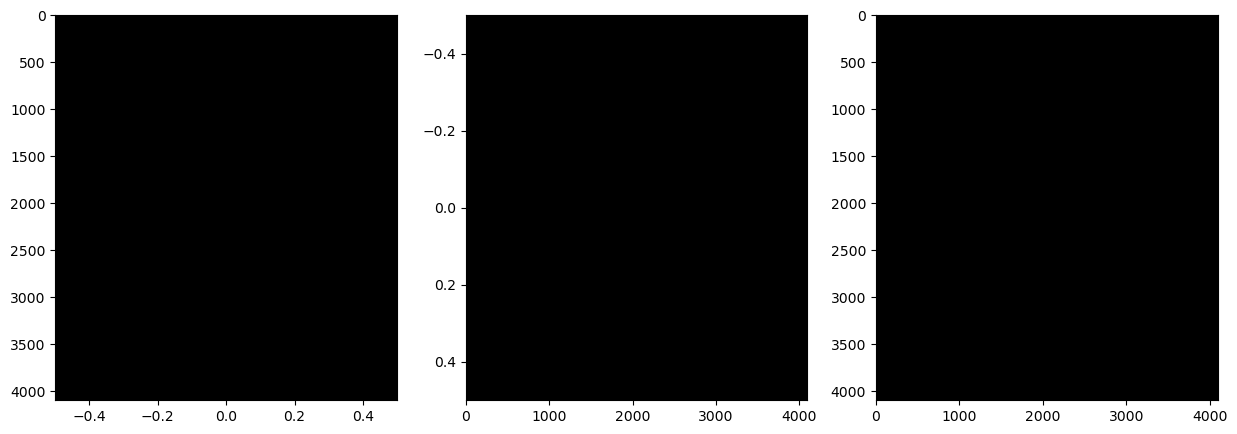

In [11]:
cmap = "gray"
fig,axs = plt.subplots(1,3, figsize = (15,5))

plt.sca(axs[0])
plt.imshow(row_mask.unsqueeze(1).cpu().numpy(), cmap = cmap, aspect = "auto")
plt.sca(axs[1])
plt.imshow(column_mask.unsqueeze(0).cpu().numpy(), cmap = cmap, aspect = "auto")
plt.sca(axs[2])
plt.imshow(mask.cpu().numpy(), cmap = cmap, aspect = "auto")

In [15]:
torch.random.manual_seed(0)
np.random.seed(0)
torch.cuda.manual_seed(0)
random.seed(0)
import tqdm
import sklearn.cluster

n_iters = 25
d = 4
k_coseine_codebook = 2**(4*2)
keep_top = 0.01

# print("average bits:", (np.log2(k_magnitude_codebook) + np.log2(k_coseine_codebook))/d)

def get_bytes(bits):
    #return as MB
    return bits/8/1024/1024


overhead = k_coseine_codebook * 16 * d

encoding_bits = (np.ceil(np.log2(k_coseine_codebook)))/d * torch.sum(mask).item()

sparse_bits = 16 * torch.sum(~mask).item()
print("sparse bits:", get_bytes(sparse_bits), "encoding bits:", get_bytes(encoding_bits.item()), "codebooks:", get_bytes(overhead), "total:", get_bytes(sparse_bits + encoding_bits + overhead))
print("bits per value:", (sparse_bits + encoding_bits + overhead)/(weights.shape[0] * weights.shape[1]))
# raise ValueError


weights_masked = weights[row_mask,:][:,column_mask]
print("weights_masked.shape = ", weights_masked.shape)
subvector_assignments = torch.arange(weights_masked.shape[1]).reshape((-1, d))
# row_assignments = torch.randperm(weights.shape[1]).reshape(-1, d)

# assert torch.isfinite(weights_masked).all()
# assert torch.isfinite(H).all()

weights_reshaped = weights_masked[:,subvector_assignments] 
print("weights_reshaped.shape = ", weights_reshaped.shape)
#shape of (n, m/d, d)

print(H[column_mask,column_mask].shape)
H_diag = H[column_mask,column_mask][subvector_assignments]
print("H_diag.shape = ", H_diag.shape)
# H_diag = torch.ones_like(weights_reshaped)
#shape of (n, m/d, d)

# raise ValueError
# print(torch.quantile(weights_norms, 1-keep_top), torch.max(weights_norms), torch.min(weights_norms))
# print(torch.sum(mask)/(mask.shape[0]*mask.shape[1]), 1 - torch.sum(mask)/(mask.shape[0]*mask.shape[1]))
# raise ValueError
#mask of the top 1% of the weights


print("weights_norms_masked.shape", weights_reshaped.shape)


mappings, codebooks = our_cluster(weights_reshaped.reshape(-1,d), k_coseine_codebook, H_diag.unsqueeze(0).expand(weights_reshaped.shape[0], -1, -1).reshape(-1,d), n_iter = n_iters)
#mapping of shape (m/d*n)
#codebooks of shape (k, d)

weights_reconstructed = torch.empty_like(weights_masked)
weights_reconstructed[:,subvector_assignments] = codebooks[mappings,:].reshape(weights_reconstructed.shape[0], -1, d)




weights_quantized = torch.empty_like(weights)

weights_quantized[mask] = weights_reconstructed.flatten()
weights_quantized[~mask] = weights[~mask]


diff = weights - weights_quantized

average_error = torch.sum(torch.abs(diff)**1)/torch.sum(torch.abs(weights)**1)

H_error = torch.einsum('ik,kl,il->', diff, H/H.shape[0], diff)

free, total = torch.cuda.mem_get_info(device)
print(f"free = {free/1024/1024}, total = {total/1024/1024}")

print(f"average error {average_error}, H error {H_error}")

sparse bits: 0.0 encoding bits: 4.0 codebooks: 0.001953125 total: 4.001953125
bits per value: 2.0009765625
weights_masked.shape =  torch.Size([4096, 4096])
weights_reshaped.shape =  torch.Size([4096, 1024, 4])
torch.Size([4096])
H_diag.shape =  torch.Size([1024, 4])
weights_norms_masked.shape torch.Size([4096, 1024, 4])
free = 45236.0625, total = 48676.75
average error 0.402452290058136, H error 16.524765014648438


In [ ]:
#change all the codebooks

entropy: tensor(7.6997, device='cuda:5')


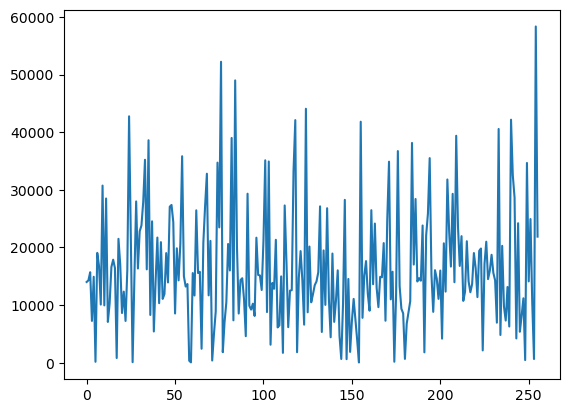

In [20]:
unique_mappings, counts = torch.unique(mappings, return_counts = True)

plt.plot(counts.cpu().numpy())
entropy = -torch.sum((counts/counts.sum())*torch.log2(counts/counts.sum()))
print("entropy:", entropy)

(array([2.88614e+05, 4.20748e+05, 3.28144e+05, 4.19711e+05, 4.65146e+05,
        4.14556e+05, 1.78999e+05, 2.52222e+05, 2.92580e+05, 2.06419e+05,
        1.49267e+05, 1.54631e+05, 6.39610e+04, 7.93140e+04, 1.02992e+05,
        3.00400e+04, 4.38840e+04, 3.57320e+04, 1.01214e+05, 2.20090e+04,
        1.66140e+04, 2.01170e+04, 1.24530e+04, 2.48750e+04, 1.19010e+04,
        4.60300e+03, 9.55400e+03, 8.62800e+03, 0.00000e+00, 4.98500e+03,
        4.66600e+03, 0.00000e+00, 0.00000e+00, 3.12500e+03, 0.00000e+00,
        3.64600e+03, 0.00000e+00, 1.80000e+03, 8.20900e+03, 0.00000e+00,
        0.00000e+00, 1.71200e+03, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 8.15000e+02, 3.48000e+02, 2.78300e+03, 0.00000e+00,
        8.44000e+02, 6.41000e+02, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00

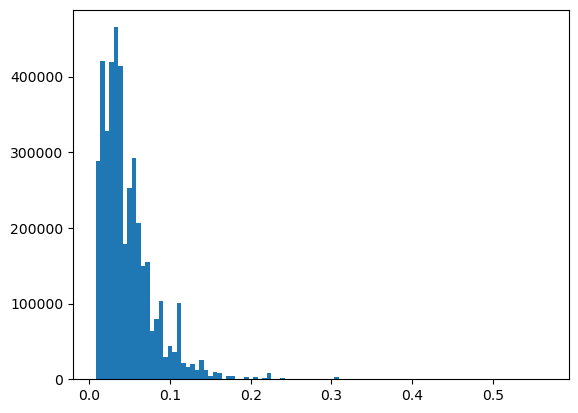

In [19]:
plt.hist(torch.norm(codebooks, dim = 1)[mappings].cpu().numpy(), bins = 100)    

In [9]:
class JLCM_update_model(nn.Module):
    def __init__(self, codebook, mappings, scaling = 1.2, bias = -0.1, initial = 1):
        super().__init__()
        self.codebook = nn.Parameter(codebook.clone()) #shape of (k, d)

        mappings_use = torch.zeros((mappings.shape[0], codebook.shape[0]), dtype = torch.float32, device = mappings.device) - initial

        mappings_use[torch.arange(mappings.shape[0]), mappings] = initial
        self.mappings = nn.Parameter(mappings_use)

        self.scaling = scaling
        self.bias = bias
    
    def forward(self):
        
        mappings_sigmoid = torch.sigmoid(self.mappings)* self.scaling + self.bias

        # print(mappings_sigmoid.shape, self.codebook.shape)
        return mappings_sigmoid @ self.codebook, mappings_sigmoid #shape of (n, d)

    def regularization_loss(self, mappings_sigmoid, beta, binary_penalty_weight, 
                            sum_cutoff, sum_penalty_weight):
        
        binary_penalty = torch.sum(1-torch.abs(2*mappings_sigmoid-1)**beta)

        sum_penalty_weight = torch.sum(torch.abs(torch.sum(mappings_sigmoid, dim = 1) - sum_cutoff))

        return binary_penalty_weight * binary_penalty + sum_penalty_weight * sum_penalty_weight
    
    def rounded_forward(self, cutoff:int = 3):

        mappings_sigmoid = torch.sigmoid(self.mappings) * self.scaling + self.bias
        print(mappings_sigmoid)
        cutoffs = torch.sort(mappings_sigmoid, dim = 1).values[:,-cutoff].unsqueeze(1) #shape of (n, 1)
        print(cutoffs[0])
        mappings_sigmoid = (mappings_sigmoid > cutoffs).float()
        print(mappings_sigmoid[0])
        assert torch.sum(mappings_sigmoid) == mappings_sigmoid.shape[0] * cutoff

        return mappings_sigmoid @ self.codebook #shape of (n, d)

        





In [39]:
JLCM = JLCM_update_model(codebooks, mappings, initial = 1)
optimizer = torch.optim.Adam(JLCM.parameters(), lr = 1e-3)
free, total = torch.cuda.mem_get_info(device)
print(f"free = {free/1024/1024}, total = {total/1024/1024}")

# raise ValueError

n_iters = 2500
lr = 1e-3
clamp_gradients = 1e-1
prev_loss = 1e10

lambda_1 = 1
lambda_2 = 1000

beta_scheduler = torch.linspace(10, 1, n_iters)

for i in range(n_iters):
    weights_reconstructed = torch.empty_like(weights_masked)
    
    tmp, m = JLCM()
    weights_reconstructed[:,subvector_assignments] = tmp.reshape(weights_reconstructed.shape[0], -1, d)
    
    regularization_loss = JLCM.regularization_loss(m, beta_scheduler[i], lambda_1, 4, lambda_2)


    weights_quantized = torch.empty_like(weights)

    weights_quantized[mask] = weights_reconstructed.flatten()
    weights_quantized[~mask] = weights[~mask]

    diff = weights - weights_quantized
    average_error = torch.sum(torch.abs(diff)**1)/torch.sum(torch.abs(weights)**1)

    H_error = torch.einsum('ik,kl,il->', diff, H/H.shape[0], diff)


    if i % (n_iters//10) == 0:
        print(f"average error {average_error}, H error {H_error}")
    # print(f"average error {average_error}, H error {H_error}")
    
    loss = H_error + regularization_loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # raise ValueError


free = 10277.0, total = 48676.75
average error 0.6761813759803772, H error 35.55479431152344
average error 0.5656991004943848, H error 3.5576915740966797
average error 0.5619010329246521, H error 3.3037867546081543
average error 0.5615885853767395, H error 3.277555227279663
average error 0.5616160035133362, H error 3.271946430206299
average error 0.5616722702980042, H error 3.2692551612854004
average error 0.5617244243621826, H error 3.2674152851104736
average error 0.5617690086364746, H error 3.2661681175231934
average error 0.5618055462837219, H error 3.2654178142547607
average error 0.5618343949317932, H error 3.2650279998779297


In [31]:
with torch.no_grad():
    weights_reconstructed = torch.empty_like(weights_masked)
    
    tmp= JLCM.rounded_forward()
    weights_reconstructed[:,subvector_assignments] = tmp.reshape(weights_reconstructed.shape[0], -1, d)



    weights_quantized = torch.empty_like(weights)

    weights_quantized[mask] = weights_reconstructed.flatten()
    weights_quantized[~mask] = weights[~mask]

    diff = weights - weights_quantized
    average_error = torch.sum(torch.abs(diff)**1)/torch.sum(torch.abs(weights)**1)

    H_error = torch.einsum('ik,kl,il->', diff, H/H.shape[0], diff)
    print(f"average error {average_error}, H error {H_error}")

tensor([[0.0943, 0.0943, 0.0943,  ..., 0.0943, 0.0943, 0.0943],
        [0.0943, 0.0943, 0.0943,  ..., 0.0943, 0.0943, 0.0943],
        [0.0943, 0.0943, 0.0943,  ..., 0.0943, 0.0943, 0.0943],
        ...,
        [0.0943, 0.0943, 0.0943,  ..., 0.0943, 0.0943, 0.0943],
        [0.0943, 0.0943, 0.0943,  ..., 0.0943, 0.0943, 0.0943],
        [0.0943, 0.0943, 0.0943,  ..., 0.0943, 0.0943, 0.0943]],
       device='cuda:5')
tensor([0.0943], device='cuda:5')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:5')


AssertionError: 

In [41]:
torch.sum(m[0])

tensor(4.1198, device='cuda:5', grad_fn=<SumBackward0>)

In [34]:
m[0]

tensor([0.2227, 0.2227, 0.2227, 0.2227, 0.2227, 0.2227, 0.2227, 0.2227, 0.2227,
        0.2227, 0.2227, 0.2227, 0.2227, 0.2227, 0.2227, 0.2227, 0.2227, 0.2227,
        0.2227, 0.2227, 0.2227, 0.2227, 0.2227, 0.2227, 0.2227, 0.2227, 0.2227,
        0.2227, 0.2227, 0.2227, 0.2227, 0.2227, 0.2227, 0.2227, 0.2227, 0.2227,
        0.2227, 0.2227, 0.2227, 0.2227, 0.2227, 0.2227, 0.2227, 0.7773, 0.2227,
        0.2227, 0.2227, 0.2227, 0.2227, 0.2227, 0.2227, 0.2227, 0.2227, 0.2227,
        0.2227, 0.2227, 0.2227, 0.2227, 0.2227, 0.2227, 0.2227, 0.2227, 0.2227,
        0.2227], device='cuda:5', grad_fn=<SelectBackward0>)

In [28]:

codebooks_use = codebooks.clone().requires_grad_(True)


n_iters = 100
lr = 1e-3
clamp_gradients = 1e-1
prev_loss = 1e10

for i in range(n_iters):
    weights_reconstructed = torch.empty_like(weights_masked)
    weights_reconstructed[:,subvector_assignments] = codebooks_use[mappings,:].reshape(weights_reconstructed.shape[0], -1, d)




    weights_quantized = torch.empty_like(weights)

    weights_quantized[mask] = weights_reconstructed.flatten()
    weights_quantized[~mask] = weights[~mask]

    diff = weights - weights_quantized
    average_error = torch.sum(torch.abs(diff)**1)/torch.sum(torch.abs(weights)**1)

    H_error = torch.einsum('ik,kl,il->', diff, H/H.shape[0], diff)
    print(f"average error {average_error}, H error {H_error}")
    H_error.backward()

    if H_error > prev_loss:
        lr = lr/2
        print("reducing lr to ", lr)
    prev_loss = H_error.item()
    with torch.no_grad():

        codebooks_use.grad = torch.clamp(codebooks_use.grad, -clamp_gradients, clamp_gradients)
        codebooks_use -= lr * codebooks_use.grad
        codebooks_use.grad.zero_()

average error 0.3639007806777954, H error 2.1907880306243896
average error 0.3641906976699829, H error 2.1580913066864014
average error 0.36452025175094604, H error 2.1266045570373535
average error 0.3648882210254669, H error 2.0963268280029297
average error 0.36529338359832764, H error 2.067253589630127
average error 0.3657330572605133, H error 2.0393872261047363
average error 0.3662051856517792, H error 2.0127198696136475
average error 0.36670711636543274, H error 1.9872446060180664
average error 0.36723563075065613, H error 1.962950587272644
average error 0.3677878975868225, H error 1.9398267269134521
average error 0.3683556914329529, H error 1.9178714752197266
average error 0.36893171072006226, H error 1.8970626592636108
average error 0.36950749158859253, H error 1.877370834350586
average error 0.37006834149360657, H error 1.8587566614151
average error 0.37060239911079407, H error 1.841153621673584
average error 0.3711072504520416, H error 1.8244866132736206
average error 0.3715787

In [15]:
# import pca
import sklearn.decomposition

pca = sklearn.decomposition.PCA(n_components = 2)

#perform a pca on the weights
weights_pca = pca.fit_transform(weights_use.cpu().numpy())

#transform the old codebooks and the new codebooks
codebooks_pca = pca.transform(codebooks_use.cpu().detach().numpy())
codebooks_old_pca = pca.transform(codebooks.cpu().numpy())

outliers_pca = pca.transform(weights_reshaped[~mask_norm,:].cpu().numpy())
H_large_pca = pca.transform(weights_reshaped[~mask_H,:].cpu().numpy())

#plot out countour plot of the weights
import matplotlib.pyplot as plt
import seaborn as sns


KeyboardInterrupt: 

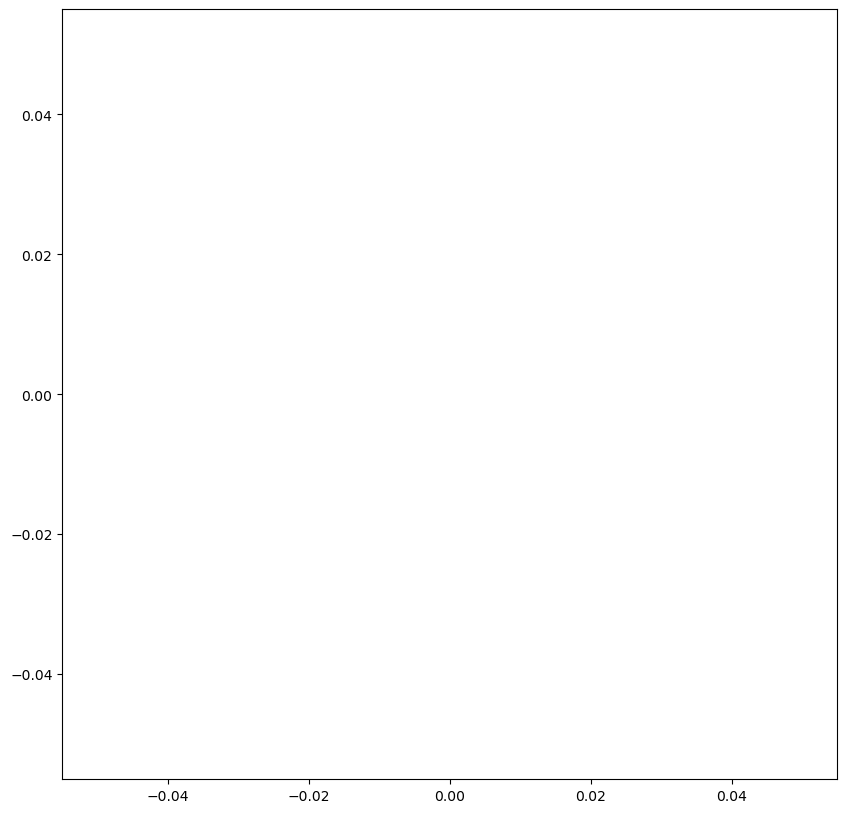

In [17]:
#plot out countour plot of the weights
import matplotlib.pyplot as plt
import seaborn as sns

n_plot = 40000
indicies = np.random.choice(weights_pca.shape[0], n_plot, replace = False)

plt.figure(figsize=(10,10))
sns.kdeplot(x=weights_pca[indicies,0], y=weights_pca[indicies,1], fill = True)

plt.scatter(codebooks_pca[:,0], codebooks_pca[:,1], c = 'r', label = "new codebooks", s = 10)
plt.scatter(codebooks_old_pca[:,0], codebooks_old_pca[:,1], c = 'g', label = "old codebooks",
            s = 10)

#draw arrrows between the old and new codebooks
for i in range(codebooks_pca.shape[0]):
    plt.arrow(codebooks_old_pca[i,0], codebooks_old_pca[i,1], codebooks_pca[i,0] - codebooks_old_pca[i,0],
              codebooks_pca[i,1] - codebooks_old_pca[i,1], head_width=0.005, head_length=0.005, fc='k', ec='k')

# plt.scatter(outliers_pca[:,0], outliers_pca[:,1], c = 'y', label = "outliers", s = 1, alpha = 0.5)
# plt.scatter(H_large_pca[:,0], H_large_pca[:,1], c = 'b', label = "H large", s = 1, alpha = 0.5)
plt.legend()
plt.title("Weights distribution")

In [11]:


soft_one_hot_value = 5
# for i in range(k_magnitude_codebook):
    # if codebooks[i].shape[0] < k_coseine_codebook:
    #     continue
codebooks_use = codebooks.clone().requires_grad_(True)



mappings_use_ = torch.zeros((k_coseine_codebook, mappings.shape[0]), dtype = codebooks_use.dtype, device = codebooks.device)
# print(assignments_dict[i].shape)
mappings_use_[mappings, torch.arange(mappings.shape[0])] = soft_one_hot_value

mappings_use_ = mappings_use_.clone().requires_grad_(True)
# raise ValueError
# magnitude_codebook_use = magnitude_codebook[:,0].clone()
n_iters = 100
lr = 1e-3
lr_map = 1e-3
clamp_gradients = 1e-1
prev_loss = 1e10

lambda_ = 0.1
betas = np.linspace(8,1, n_iters)

losses = []
 
for iters in range(n_iters):
    beta = betas[iters]

    weights_reconstructued_flat =  torch.zeros_like(weights_reshaped)

    weights_reconstructued_flat[~mask,:] = weights_reshaped[~mask]
    # print(codebooks_use[0])

    regularization_loss = 0 

    assignments_ = torch.softmax(mappings_use_, dim = 0)
    # raise ValueError
    # print(assignments_.shape)
    # print(codebooks_use[i].shape)
    # weights_reconstructued_flat[mask_,:] = codebooks_use[i][assignments_dict[i],:]
    regularization_loss = torch.sum(1 - torch.abs(2*assignments_ - 1)**beta)
    # weights_reconstructued_flat[mask_,:] = torch.clip(codebooks_use[i][assignments_dict[i],:],-1,1) * torch.exp(magnitude_codebook_use[i])
    weights_reconstructued_flat[mask,:] = assignments_.T @ codebooks_use



    weights_reconstructued = torch.empty_like(weights)

    weights_reconstructued[:,row_assignments] = weights_reconstructued_flat.reshape(weights_reconstructued.shape[0], -1, d)
    # print(weights_reconstructued)

    diff = weights - weights_reconstructued
    average_error = torch.sum(torch.abs(diff)**1)/torch.sum(torch.abs(weights)**1)


    H_error = torch.einsum('ik,kl,il->', diff, H/H.shape[0], diff)

    loss = H_error + lambda_ * regularization_loss
    print(f"average error {average_error}, H error {H_error}, regularization_loss = {regularization_loss}")
    loss.backward()
    losses.append(H_error.item())
    if H_error > prev_loss:
        lr = lr * 0.9
        print("reducing lr to ", lr)
    prev_loss = H_error.item()
    with torch.no_grad():
        # codebooks_use.grad = torch.clamp(codebooks_use.grad, -clamp_gradients, clamp_gradients)
        # codebooks_use -= lr * codebooks_use.grad
        # codebooks_use.grad.zero_()
        # print(mappings_use_.grad)
        mappings_use_.grad = torch.clamp(mappings_use_.grad, -clamp_gradients, clamp_gradients)
        mappings_use_ -= lr_map * mappings_use_.grad
        mappings_use_.grad.zero_()
        codebooks_use.grad.zero_()
        # magnitude_codebook_use -= torch.clip(lr * magnitude_codebook_lr_mult * magnitude_codebook_use.grad, -clamp_gradients*magnitude_codebook_lr_mult, clamp_gradients*magnitude_codebook_lr_mult)
        # magnitude_codebook_use.grad = None



average error 0.45272842049598694, H error 8.723808288574219, regularization_loss = 18361468.0
average error 0.45272859930992126, H error 8.72304916381836, regularization_loss = 18237976.0
average error 0.4527287185192108, H error 8.72229290008545, regularization_loss = 18114116.0
average error 0.45272889733314514, H error 8.721476554870605, regularization_loss = 17989760.0
average error 0.45272907614707947, H error 8.72071647644043, regularization_loss = 17865062.0
average error 0.4527292549610138, H error 8.719961166381836, regularization_loss = 17739884.0
average error 0.4527294337749481, H error 8.719202995300293, regularization_loss = 17614298.0
average error 0.45272961258888245, H error 8.718391418457031, regularization_loss = 17488246.0
average error 0.452729731798172, H error 8.717632293701172, regularization_loss = 17361786.0
average error 0.4527299106121063, H error 8.716875076293945, regularization_loss = 17234872.0
average error 0.45273008942604065, H error 8.71611976623535

In [12]:
assignments_[:,0]

tensor([0.0061, 0.0061, 0.0061, 0.0061, 0.0061, 0.9090, 0.0061, 0.0061, 0.0061,
        0.0061, 0.0061, 0.0061, 0.0061, 0.0061, 0.0061, 0.0061],
       device='cuda:6', grad_fn=<SelectBackward0>)

In [56]:
assignments_new = {i: assignments_use[i].argmax(0) for i in assignments_use}

weights_reconstructued_flat =  torch.zeros_like(weights_reshaped)

weights_reconstructued_flat[~mask,:] = weights_reshaped[~mask]
# print(codebooks_use[0])

with torch.no_grad():

    regularization_loss = 0
    for i in range(k_magnitude_codebook):
        mask_i = magnitude_assignments == i
        assert torch.any(mask_i)
        mask_ = torch.zeros_like(mask)
        mask_[mask] = mask_i
        if i not in codebooks_use:
            weights_reconstructued_flat[mask_,:] = codebooks[i][assignments_dict[i],:] * torch.exp(magnitude_codebook_use[i])
            continue    

        weights_reconstructued_flat[mask_,:] = torch.clip(codebooks_use[i][assignments_new[i],:],-1,1) * torch.exp(magnitude_codebook_use[i])
    # weights_reconstructued_flat[mask,:] = centriods[assignments,:] * torch.from_numpy(np.exp(magnitude_codebook[:,0][magnitude_assignments])).reshape(-1,1).float()


    weights_reconstructued = torch.empty_like(weights)

    weights_reconstructued[:,row_assignments] = weights_reconstructued_flat.reshape(weights_reconstructued.shape[0], -1, d)
    # print(weights_reconstructued)

    diff = weights - weights_reconstructued
    average_error = torch.sum(torch.abs(diff)**1)/torch.sum(torch.abs(weights)**1)


H_error = torch.einsum('ik,kl,il->', diff, H/H.shape[0], diff)

loss = H_error + lambda_ * regularization_loss
print(f"average error {average_error}, H error {H_error}")

average error 0.5536376237869263, H error 5.610358715057373


In [57]:
n_change = 0
for i in codebooks_use:

    n_change += torch.sum(assignments_new[i] != assignments_dict[i])

print("n_change = ", n_change)

n_change =  tensor(0, device='cuda:6')


In [58]:
assignments_dict[0]

tensor([15, 11,  1,  ...,  2,  8,  9], device='cuda:6')

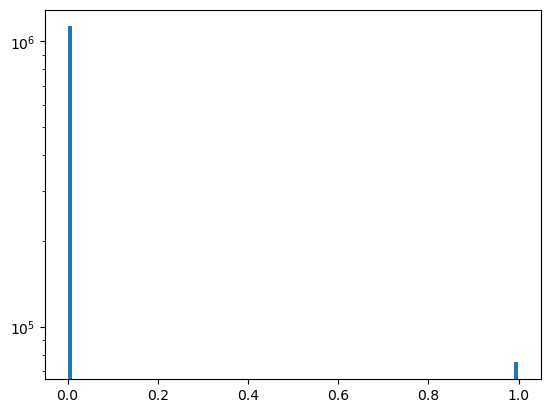

In [59]:
plt.hist(assignments_.detach().cpu().numpy().flatten(), bins = 100)
plt.yscale('log')

In [61]:
assignments_use[0][assignments_dict[0],:].detach().cpu().numpy()

array([[ 9.9999952e+00,  1.2635506e-07,  1.5326428e-07, ...,
        -5.7824224e-08, -1.2287417e-07, -4.6445859e-08],
       [ 1.1943567e-07,  9.9999952e+00,  9.9999924e+00, ...,
        -5.9382781e-08,  1.0000002e+01, -4.4714639e-08],
       [ 1.1943567e-07,  9.9999952e+00,  9.9999924e+00, ...,
        -5.9382781e-08,  1.0000002e+01, -4.4714639e-08],
       ...,
       [ 5.5878967e-08,  6.5669362e-08,  7.8594709e-08, ...,
         1.0000001e+01, -6.2216365e-08, -4.7712575e-08],
       [ 1.1943567e-07,  9.9999952e+00,  9.9999924e+00, ...,
        -5.9382781e-08,  1.0000002e+01, -4.4714639e-08],
       [ 5.4991109e-08,  6.7893268e-08,  8.2246736e-08, ...,
        -6.4254273e-08, -6.5741027e-08,  1.0000002e+01]], dtype=float32)

In [62]:
codebooks[i][assignments_dict[i],:]

tensor([[ 4.3442e-02, -4.5606e-02,  7.5983e-02,  ...,  1.2069e-02,
          7.2188e-02,  1.0297e-04],
        [ 4.3442e-02, -4.5606e-02,  7.5983e-02,  ...,  1.2069e-02,
          7.2188e-02,  1.0297e-04],
        [ 4.3442e-02, -4.5606e-02,  7.5983e-02,  ...,  1.2069e-02,
          7.2188e-02,  1.0297e-04],
        ...,
        [-1.5629e-01,  1.7860e-01, -4.9690e-02,  ..., -1.5907e-01,
          2.4043e-02,  4.6148e-02],
        [-1.3026e-01,  3.9753e-02, -6.5690e-02,  ..., -5.2088e-02,
         -3.5687e-01,  9.4983e-02],
        [ 2.4803e-02, -3.7862e-01,  2.0537e-01,  ..., -2.6397e-02,
         -9.8013e-02, -3.7012e-02]], device='cuda:6')

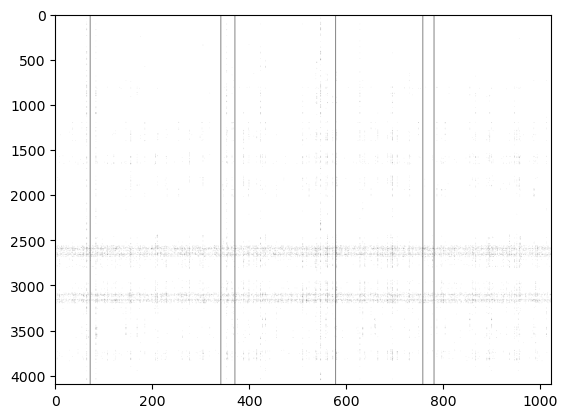

In [18]:
plt.imshow(mask.cpu().numpy(),aspect = 'auto', cmap = 'gray')

Text(0.5, 1.0, 'Hessian Mask')

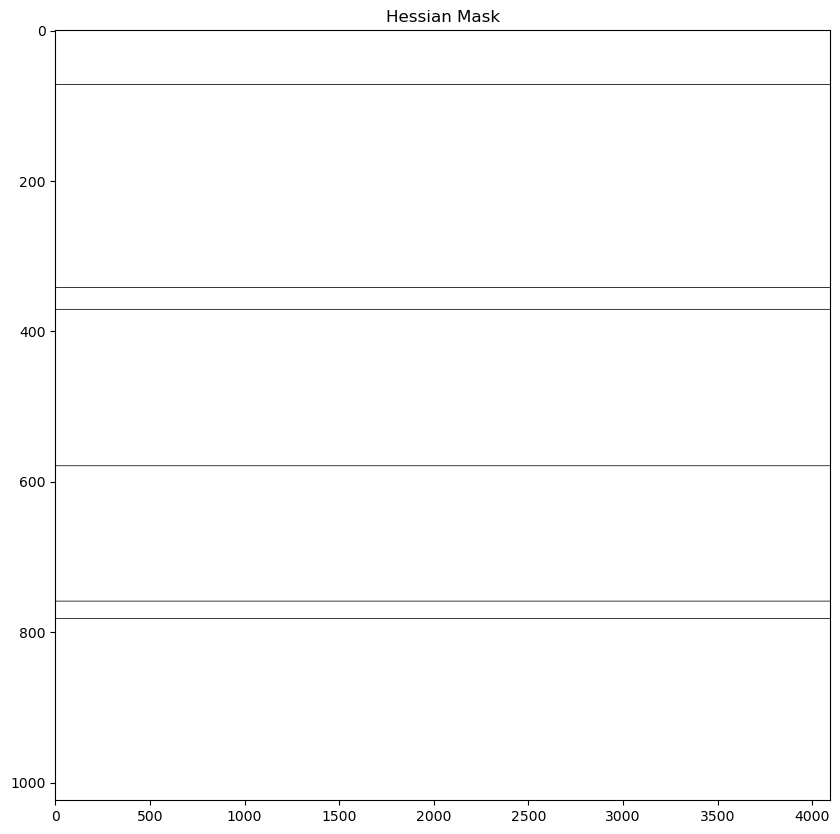

In [24]:
plt.figure(figsize = (10,10))
plt.imshow(mask_H.T.cpu().numpy(),aspect = 'auto', cmap = 'gray')
plt.title("Hessian Mask")

Text(0.5, 1.0, 'Norm Mask')

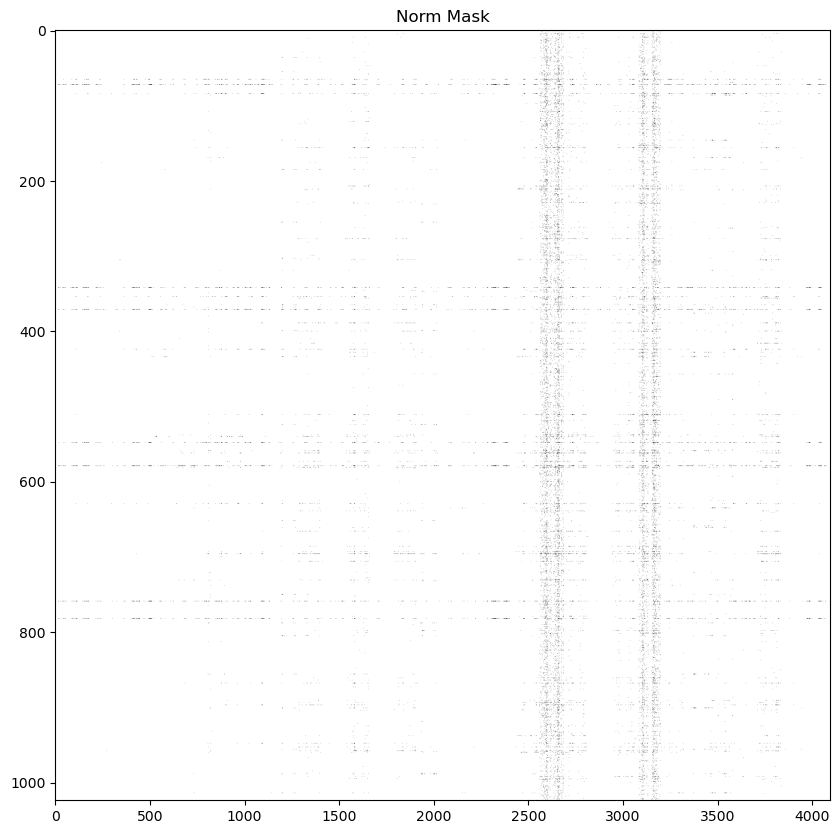

In [25]:
plt.figure(figsize=(10,10))
plt.imshow(mask_norm.T.cpu().numpy(),aspect = 'auto', cmap = 'gray')
plt.title("Norm Mask")

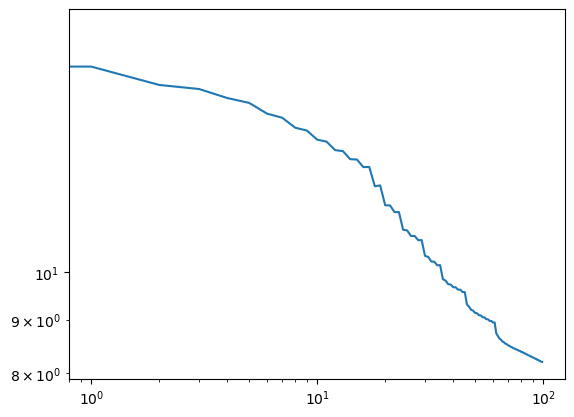

In [15]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.yscale("log")
plt.xscale("log")